In [2]:
%load_ext autoreload
%autoreload 2

import gudhi
import numpy as np

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_removed_outliers
from functions.data_filtering import complete_flight_filter
from functions.data_filtering import filter_by_bools, filter_flights
from functions.objects import PersistenceData

from datetime import datetime
from collections import Counter
from tqdm import tqdm
from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt

In [3]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
trees, paths, file_name = get_flight_persistence(None, file_name, load_results=True)

In [4]:
pers_data = PersistenceData(trees, paths, "LL")

In [5]:
condensed_distance_matrix = []

for i in tqdm(range(len(trees))):
    for j in range(i+1, len(trees)):
        tree_i = trees[i]
        tree_j = trees[j]
        dist = gudhi.bottleneck_distance(tree_i, tree_j, 0.0001)
        condensed_distance_matrix.append(dist)

100%|██████████| 6948/6948 [00:33<00:00, 206.10it/s] 


In [6]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sys
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

clustering = fcluster(Z, t=1.1, criterion='inconsistent', depth=2)
#clustering = fcluster(Z, t=10, criterion='maxclust', depth=2)

In [7]:
for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")


1: 3
2: 7
3: 2
4: 2
5: 4
6: 3
7: 3
8: 2
9: 3
10: 6887
11: 14
12: 2
13: 2
14: 2
15: 3
16: 1
17: 8


3


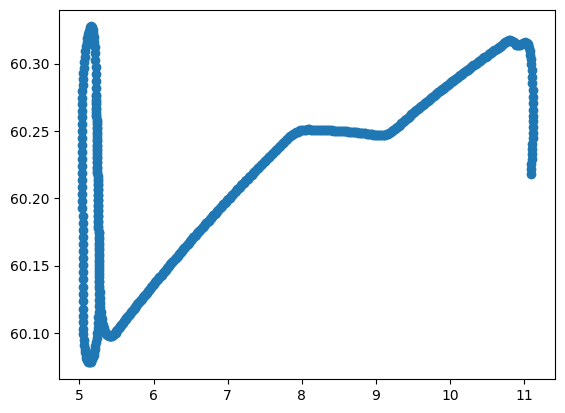

In [8]:
bool_array = clustering == 1

loopy_flight_cluster = filter_flights(filter_by_bools(bool_array), pers_data.paths)
loopy_flight_cluster_pers = list(filter(filter_by_bools(bool_array), pers_data.paths))
print(len(loopy_flight_cluster))
loopy_flight = loopy_flight_cluster[2]
plt.scatter(loopy_flight[:,1], loopy_flight[:,0])

In [38]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from collections import Counter

dbscan = DBSCAN(eps=0.1, min_samples=2)
k_means = KMeans(n_clusters=2, random_state=0)
optics = OPTICS()

data = pers_data.stats

normalizer = preprocessing.StandardScaler()
data = normalizer.fit_transform(data)

clusterings = {}

for cluster_method in [dbscan, k_means, optics]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(pers_data.stats)
    clusterings[method_name] = clustering
    
    print(f"{method_name.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Dbscan:
-1: 72 | 0: 6855 | 1: 6 | 2: 3 | 3: 2 | 4: 2 | 5: 2 | 6: 2 | 7: 4
Kmeans:
0: 6936 | 1: 12
Optics:
-1: 12 | 0: 6855 | 1: 7 | 2: 6 | 3: 8 | 4: 23 | 5: 10 | 6: 5 | 7: 11 | 8: 5 | 9: 6


6


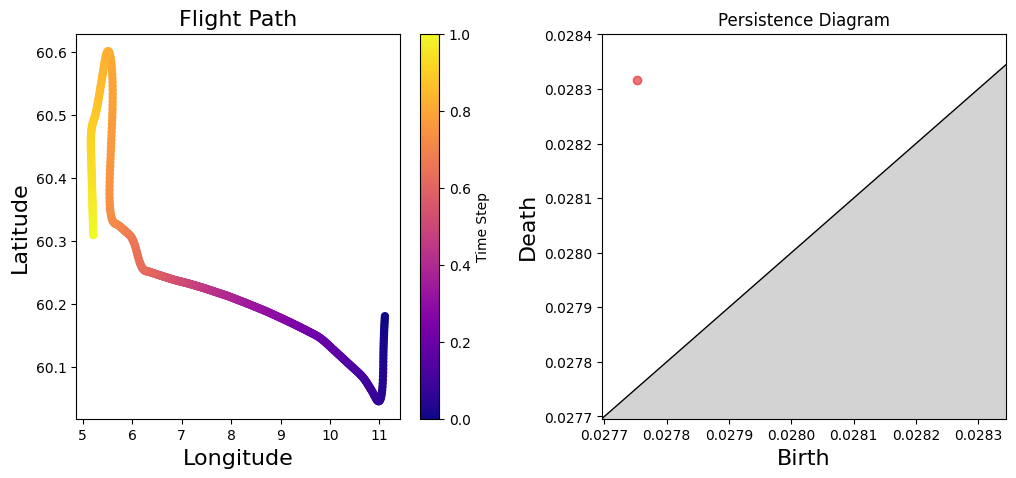

In [39]:
clustering = clusterings["DBSCAN"]
cluster = np.where(clustering == 1)[0]
print(len(cluster))

fig = pers_data.plot_diagram(cluster[4])
